In [1]:
%matplotlib inline

In [2]:
# This notebook calculates 21-day centered rolling mean for precipitation and temperature from ERA5-Land across Iceland
# and plots the results (Figure 6 in the manuscript)

In [2]:
import xarray as xr
import pandas as pd
from pathlib import Path
import os

In [ ]:
# First, run this in Google Earth Engine:
# // ----------------------------
# // 1. Define Iceland Geometry
# // ----------------------------
# var iceland = ee.Geometry.Rectangle([-25, 63, -12, 67]);

# // ----------------------------
# // 2. Load ERA5-Land Collection
# // ----------------------------
# var era5 = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR')
#   .filterDate('1950-10-01', '2024-10-01')  // Covers Oct 1, 1950 to Sep 30, 2024
#   .select(['temperature_2m', 'total_precipitation_sum', 'snowfall_sum']);

# // ----------------------------
# // 3. Function to extract daily mean over Iceland
# // ----------------------------
# var dailyStats = era5.map(function(img) {
#   var date = img.date().format('YYYY-MM-dd');

#   var stats = img.reduceRegion({
#     reducer: ee.Reducer.mean(),
#     geometry: iceland,
#     scale: 10000,
#     maxPixels: 1e9
#   });

#   return ee.Feature(null, stats.set('date', date));
# });

# // ----------------------------
# // 4. Export to Google Drive
# // ----------------------------
# Export.table.toDrive({
#   collection: dailyStats,
#   description: 'ERA5Land_Daily_Means_Iceland',
#   fileFormat: 'CSV'
# });


In [ ]:
# Now we download the data from Google Drive that was prepared in the cell above, and load it in:
fpath = Path(r"ERA5Land_Daily_Means_Iceland.csv")
daily_era5_df = pd.read_csv(fpath)
daily_era5_df.set_index('date', inplace=True)
daily_era5_df.index = pd.to_datetime(daily_era5_df.index)   
daily_era5_df.drop(columns=['system:index','.geo'], inplace=True)
daily_era5_df.rename(columns={
    'temperature_2m': 't2m',
    'total_precipitation_sum': 'tp',
    'snowfall_sum': 'snowfall'
}, inplace=True)  

# Convert temperature from Kelvin to Celsius
daily_era5_df['t2m'] = daily_era5_df['t2m'] - 273.15
# Convert precipitation from meters to mm
daily_era5_df['tp'] = daily_era5_df['tp'] * 1000
# Convert snowfall from meters to mm    
daily_era5_df['snowfall'] = daily_era5_df['snowfall'] * 1000

# Plot figures

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
sns.set()

save_path = Path(r"C:\Users\hordurbhe\OneDrive - Landsvirkjun\Changes in streamflow in Iceland\paper\HESS peer review process\Revised manuscript\Figures")

def calculate_and_plot_trends_comparison(df, variable_name, start_year1, end_year1, start_year2, end_year2, window_length=21, use_percentage=False, ax=None):
    """
    Calculate 21-day moving averages, compute daily trends for two periods, and visualize the comparison.
    
    Parameters:
        df (pd.DataFrame): Daily time series with a DatetimeIndex and one column for the variable.
        variable_name (str): Name of the variable (e.g., "Precipitation (mm)" or "Temperature (°C)").
        start_year1 (int): Start year for the first period.
        end_year1 (int): End year for the first period.
        start_year2 (int): Start year for the second period.
        end_year2 (int): End year for the second period.
        window_length (int): Window length for moving average (default: 21 days).
        use_percentage (bool): If True, calculate trends as % per decade; otherwise, use the original unit.
        ax (matplotlib.axes.Axes): Optional. Existing axis to plot on. If None, a new figure is created.
    """
    from seaborn import color_palette
    from matplotlib import rcParams
    sns.set()
    # Set font and figure settings
    rcParams['font.family'] = 'Arial'
    rcParams['font.size'] = 25
    rcParams['axes.titlesize'] = 30
    rcParams['axes.labelsize'] = 25
    rcParams['xtick.labelsize'] = 25
    rcParams['ytick.labelsize'] = 25
    rcParams['legend.fontsize'] = 20
    
    # Use colorblind-safe colors
    colors = color_palette("colorblind", n_colors=2)
    
    def calculate_trends(df, start_year, end_year):
        """
        Helper function to calculate trends for a given period.
        """
        df_period = df[str(start_year):str(end_year)]
        df_ma = df_period.rolling(window=window_length, center=True).mean()
        trends, significance = [], []

        for day in range(1, 366):
            daily_values = df_ma[df_ma.index.dayofyear == day].dropna()
            if len(daily_values) > 0:
                x = np.arange(len(daily_values))
                slope = np.polyfit(x, daily_values.values.flatten(), 1)[0]
                trend = (slope / daily_values.mean()) * 100 * 10 if use_percentage else slope * 10
                trends.append(trend)
                _, p_value = kendalltau(x, daily_values.values.flatten())
                significance.append(p_value < 0.05)
            else:
                trends.append(np.nan)
                significance.append(False)

        trend_label = "% per decade" if use_percentage else f"{variable_name} per decade"
        return pd.DataFrame({"Day of Year": np.arange(1, 366), "Trend": trends, "Significant": significance, "Trend Label": trend_label})

    # Calculate trends for both periods
    trends_df1 = calculate_trends(df, start_year1, end_year1)
    trends_df2 = calculate_trends(df, start_year2, end_year2)

    # Create a new figure if no axis is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 7))

    # Plot period 1
    ax.plot(trends_df1["Day of Year"], trends_df1["Trend"], color=colors[0], label=f"Trend {start_year1}-{end_year1}")
    ax.scatter(trends_df1["Day of Year"][trends_df1["Significant"]],
               trends_df1["Trend"][trends_df1["Significant"]],
               color=colors[0], label=f"Significant (p < 0.05) {start_year1}-{end_year1}", zorder=3)

    # Plot period 2
    ax.plot(trends_df2["Day of Year"], trends_df2["Trend"], color=colors[1], label=f"Trend {start_year2}-{end_year2}", linestyle="--")
    ax.scatter(trends_df2["Day of Year"][trends_df2["Significant"]],
               trends_df2["Trend"][trends_df2["Significant"]],
               color=colors[1], label=f"Significant (p < 0.05) {start_year2}-{end_year2}", zorder=3)

    # Add gridlines and labels
    ax.axhline(0, color="black", linestyle="--", linewidth=0.8)
    days_in_months = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365]
    month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    ax.set_xticks(days_in_months[:-1])
    ax.set_xticklabels(month_labels)
    ax.grid(linestyle="--", alpha=1)

    # Set titles and labels
    title_insert = "precipitation" if use_percentage else f"temperature"
    trend_ylabel = "% per decade" if use_percentage else f"°C per decade"
    if use_percentage:
        ax.set_title(f"b) Daily trends (21DRM) in {title_insert}, averaged over Iceland")
    else:
        ax.set_title(f"a) Daily trends (21DRM) in {title_insert}, averaged over Iceland")
    ax.set_xlabel("Month")
    #ax.set_ylabel(f"Trend in {variable_name} ({trend_ylabel})")
    ax.set_ylabel(f"{trend_ylabel}")
    ax.set_xlabel(" ")

    ax.legend()

    return trends_df1, trends_df2


In [12]:
# Set font and figure settings
from matplotlib import rcParams

rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 25
rcParams['axes.titlesize'] = 30
rcParams['axes.labelsize'] = 25
rcParams['xtick.labelsize'] = 25
rcParams['ytick.labelsize'] = 25
rcParams['legend.fontsize'] = 20

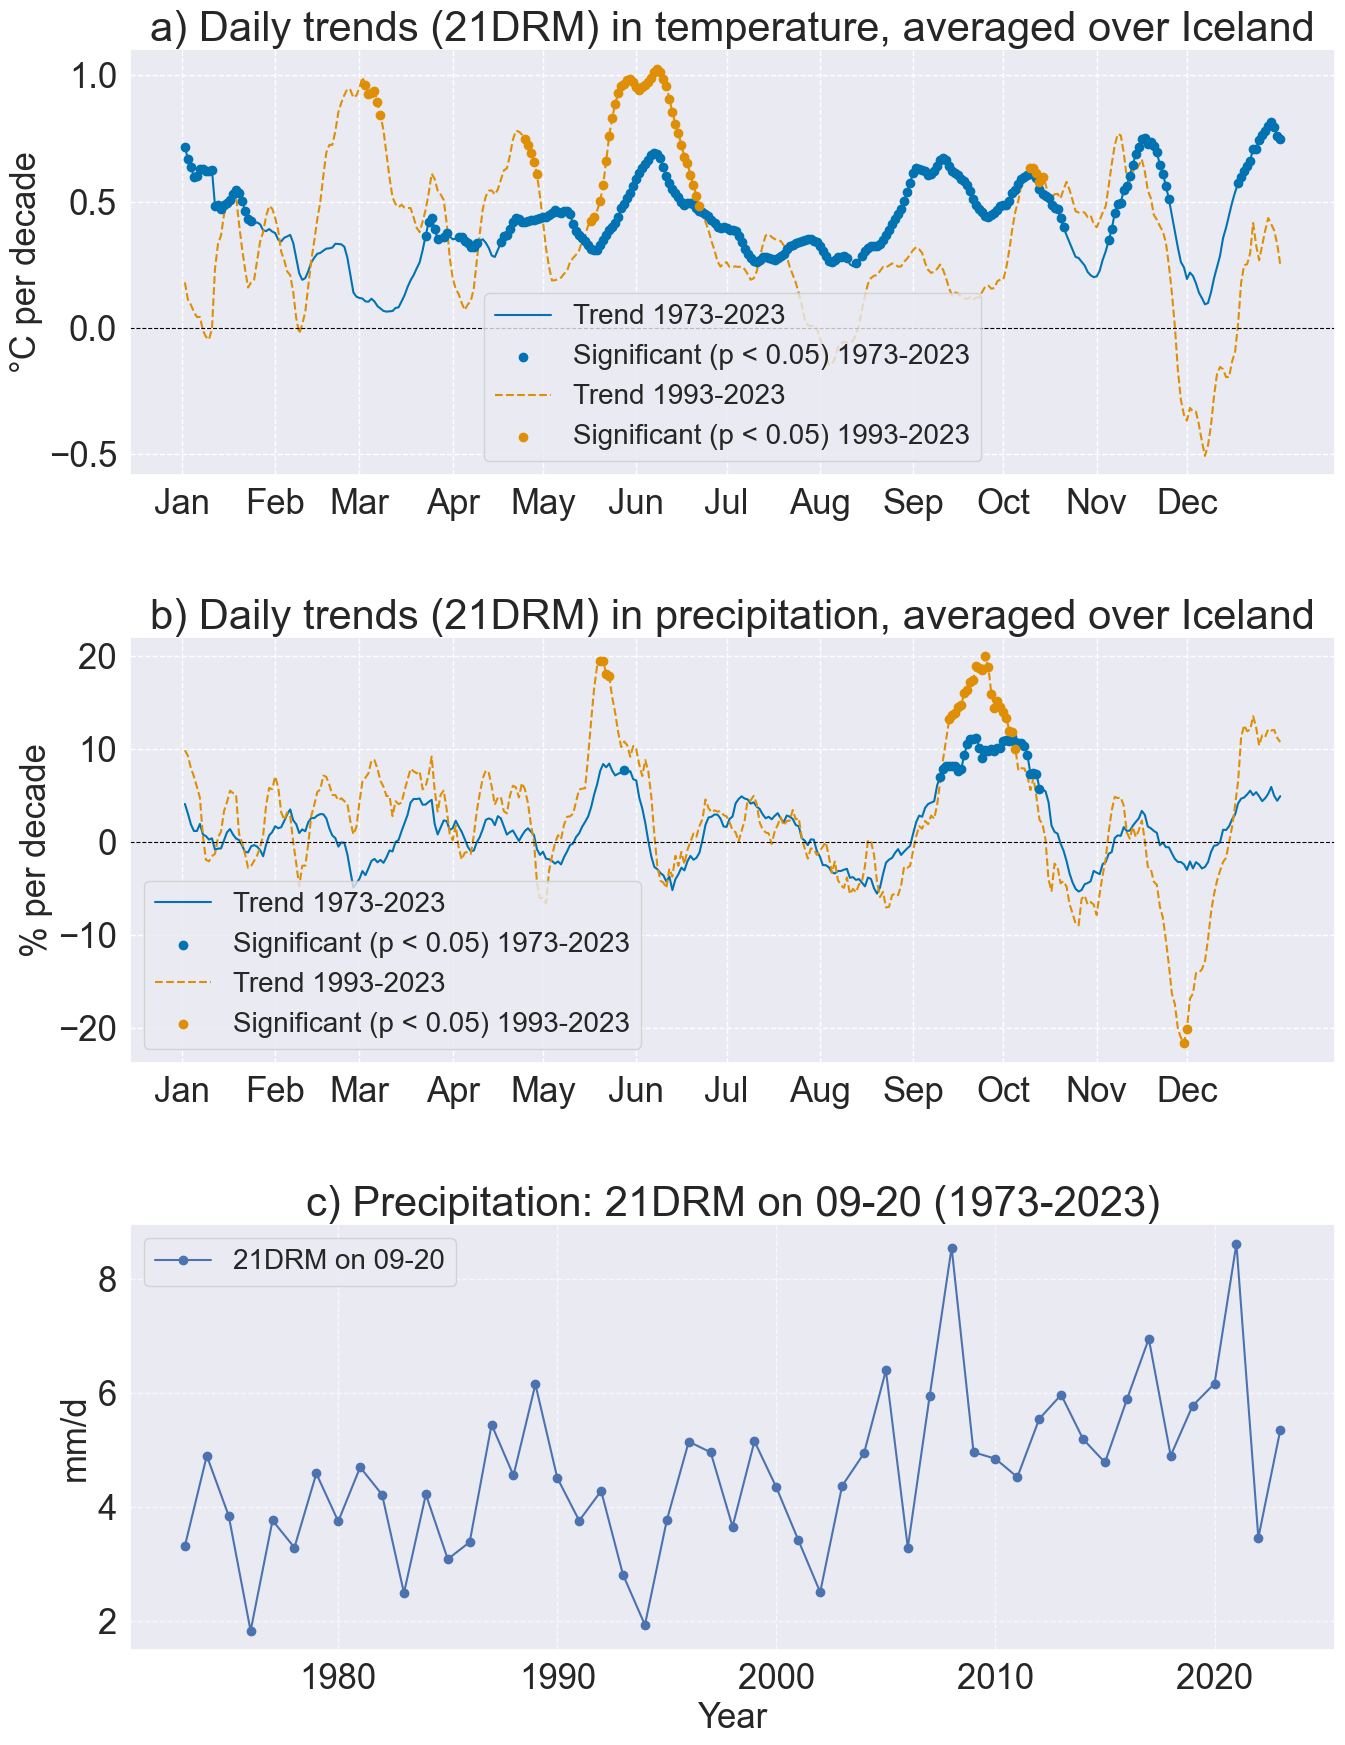

In [19]:
import os
import matplotlib.pyplot as plt

# Create a 3x1 subplot layout
fig, axes = plt.subplots(3, 1, figsize=(14, 18))

# Plot temperature trends in the first subplot
calculate_and_plot_trends_comparison(
    daily_era5_df['t2m'],
    variable_name="temperature (°C)",
    start_year1=1973,
    end_year1=2023,
    start_year2=1993,
    end_year2=2023,
    window_length=21,
    use_percentage=False,
    ax=axes[0]
)

# Plot precipitation trends in the second subplot
calculate_and_plot_trends_comparison(
    daily_era5_df['tp'],
    variable_name="precipitation (%)",
    start_year1=1973,
    end_year1=2023,
    start_year2=1993,
    end_year2=2023,
    window_length=21,
    use_percentage=True,
    ax=axes[1]
)

# Plot the 21-day moving average for September 20th in the third subplot
def extract_and_plot_series_in_subplot(ax, df, target_date, start_year, end_year, window_length=21):
    """
    Extract the 21-day moving average for a specific date across all years and plot it on a given subplot.
    
    Parameters:
        ax (matplotlib.axes.Axes): Existing axis to plot on.
        df (pd.DataFrame): Time series with a DatetimeIndex.
        target_date (str): Target date in "MM-DD" format (e.g., "09-20").
        start_year (int): Start year for the analysis.
        end_year (int): End year for the analysis.
        window_length (int): Window length for the moving average.
    """
    # Filter data for the specified years
    df_filtered = df[str(start_year):str(end_year)]

    # Calculate the 21-day moving average
    df_ma = df_filtered.rolling(window=window_length, center=True).mean()

    # Extract the values for the target date across all years
    target_series = df_ma[df_ma.index.strftime("%m-%d") == target_date]

    # Plot the extracted series
    ax.plot(target_series.index.year, target_series.values, marker='o', label=f"21DRM on {target_date}")
    ax.set_title(f"c) Precipitation: 21DRM on {target_date} ({start_year}-{end_year})")
    ax.set_xlabel("Year")
    ax.set_ylabel("mm/d")
    ax.grid(linestyle="--", alpha=0.7)
    ax.legend()

# Add the third plot to the last subplot
extract_and_plot_series_in_subplot(
    ax=axes[2],
    df=daily_era5_df['tp'],
    target_date="09-20",
    start_year=1973,
    end_year=2023,
    window_length=21
)

# Adjust layout and save the combined figure
plt.tight_layout()

savepath = os.path.join(save_path, 'Figure6_iceland_21DRM.pdf')
plt.savefig(savepath, dpi=300)

savepath = os.path.join(save_path, 'Figure6_iceland_21DRM.png')
plt.savefig(savepath, dpi=300)

plt.show()